# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets torchinfo -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.0 MB/s eta 0:00:00


# Imports and settings

In [ ]:
import collections
import os
import random
import string
import time
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm.notebook as tqdm
%matplotlib inline

import datasets
import nltk
import nltk.tokenize
import sklearn
import sklearn.model_selection

import torch
import torch.nn
import torch.functional
import torch.utils.data as data_utils
import torchinfo

In [ ]:
sns.set(style="darkgrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = (20, 20)

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Setting random seeds for reproducibility

In [ ]:
# Check CUDA version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
RANDOM_STATE = 42
def fix_seed(state):
    random.seed(state)
    os.environ["PYTHONHASHSEED"] = str(state)
    np.random.seed(state)
    torch.manual_seed(state)
    torch.cuda.manual_seed(state)
    torch.cuda.manual_seed_all(state)

fix_seed(RANDOM_STATE)

# Disable CuDNN benchmarking to eliminate related jitter. Will reduce performance a bit.
torch.backends.cudnn.benchmark = False
# See docs for torch.nn.RNN and torch.nn.LSTM for the rationale on using this workaround
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

# Set a Torch Generator with a fixed seed for more reproducibility
TORCH_RAND_GEN = torch.Generator()
TORCH_RAND_GEN.manual_seed(RANDOM_STATE)

# Determining available device

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

# Setting global variables

In [ ]:
BATCH_SIZE = 512
COUNTER_THRESHOLD = 25

# Preprocessing
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [ ]:
dataset = datasets.load_dataset("ag_news")

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [ ]:
def create_vocab(dataset, threshold=COUNTER_THRESHOLD):
    words = collections.Counter()

    for example in tqdm.tqdm(dataset["train"]["text"], desc="Preprocessing", unit="examples", unit_scale=False):
        # Lowercase and remove punctuation
        processed_text = example.lower().translate(
            str.maketrans("", "", string.punctuation))

        for word in nltk.tokenize.word_tokenize(processed_text):
            words[word] += 1


    vocab = collections.OrderedDict.fromkeys(["<unk>", "<bos>", "<eos>", "<pad>"]) # ordered replacement for set

    for char, cnt in tqdm.tqdm(words.items(), desc="Selecting frequent tokens", unit="tokens", unit_scale=False):
        if cnt > threshold:
            vocab[char] = None

    word2ind = {char: i for i, char in enumerate(vocab.keys())}
    ind2word = {i: char for char, i in word2ind.items()}

    return vocab, word2ind, ind2word

In [ ]:
vocab, word2ind, ind2word = create_vocab(dataset)

Preprocessing:   0%|          | 0/120000 [00:00<?, ?examples/s]

Selecting frequent tokens:   0%|          | 0/102166 [00:00<?, ?tokens/s]

In [ ]:
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 11842


In [ ]:
class WordDataset(data_utils.Dataset):
    def __init__(self, sentences):
        super().__init__()
        self.data = sentences
        self.unk_id = word2ind["<unk>"]
        self.bos_id = word2ind["<bos>"]
        self.eos_id = word2ind["<eos>"]
        self.pad_id = word2ind["<pad>"]

    def __getitem__(self, idx: int) -> typing.List[int]:
        processed_text = self.data[idx]["text"].lower().translate(
            str.maketrans("", "", string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in nltk.tokenize.word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]["label"]
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: typing.List[typing.List[int]], pad_id=word2ind["<pad>"], max_len=256) -> torch.Tensor:
    seq_lens = [len(x["text"]) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence["text"] = sequence["text"][:max_seq_len]
        for _ in range(max_seq_len - len(sequence["text"])):
            sequence["text"].append(pad_id)

        new_batch.append(sequence["text"])
    
    sequences = torch.LongTensor(new_batch)
    labels = torch.LongTensor([x["label"] for x in input_batch])

    new_batch = {
        "input_ids": sequences,
        "label": labels
    }

    return new_batch

In [ ]:
# The following function will use a fixed seed for DataLoader worker init
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    fix_seed(worker_seed)

In [ ]:
train_dataset = WordDataset(dataset["train"])
idx = torch.randperm(len(dataset["test"]))[:5000]
eval_dataset = WordDataset(dataset["test"].select(idx))

train_dataloader = data_utils.DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, 
    batch_size=BATCH_SIZE, num_workers=torch.multiprocessing.cpu_count(), 
    worker_init_fn=seed_worker, generator=TORCH_RAND_GEN, pin_memory=True)

eval_dataloader = data_utils.DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, 
    batch_size=BATCH_SIZE, num_workers=torch.multiprocessing.cpu_count(), 
    worker_init_fn=seed_worker, generator=TORCH_RAND_GEN, pin_memory=True)

# Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch["input_ids"].to(DEVICE))
            predictions.append(logits.argmax(dim=1))
            target.append(batch["label"])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target).to(DEVICE)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

# Ход работы
Оценка за домашнее задание складывается из четырех частей:
## Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

## Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

## Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

## Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# Baseline model definition

In [ ]:
class BaselineLM(torch.nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 4, agg_type: str = "max", dropout_rate: float = 0.1):
        super().__init__()
        self.rnn = torch.nn.Sequential(collections.OrderedDict([
            ("embedding", torch.nn.Embedding(vocab_size, hidden_dim)),
            ("rnn", torch.nn.RNN(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)),
        ]))
        self.fc = torch.nn.Sequential(collections.OrderedDict([
            ("fc0", torch.nn.Linear(hidden_dim, hidden_dim)),
            ("act0", torch.nn.Tanh()),
            ("drop", torch.nn.Dropout(p=dropout_rate)),
            ("fc1", torch.nn.Linear(hidden_dim, num_classes))
        ]))

        self.agg_type = agg_type
        if self.agg_type not in ["max", "mean"]:
            raise ValueError("Invalid aggregation type, expected one of: \"max\", \"mean\"")

    def forward(self, input):
        output, _ = self.rnn(input)

        match self.agg_type:
            case "max":
                output = output.max(dim=1)[0]
            case "mean":
                output = output.mean(dim=1)

        return self.fc(output)

# Train loop

In [ ]:
def train_epoch(train_loader, model, optimizer, criterion, epoch, epochs_count):
    model.train()
    running_loss = 0.0
    processed = 0

    for batch in tqdm.tqdm(train_loader, desc=f"Fitting epoch {epoch + 1} / {epochs_count}", unit="batch", unit_scale=False):
        try:
            input, labels = batch["input_ids"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * input.size(0)
            processed += input.size(0)
        finally:
            input, labels, output = input.cpu(), labels.cpu(), output.cpu()
            del input, labels, output
            torch.cuda.empty_cache()

    return (running_loss / processed)

def eval_epoch(val_loader, model, criterion, epoch, epochs_count):
    model.eval()
    running_loss = 0.0
    processed = 0

    for batch in tqdm.tqdm(val_loader, desc=f"Evaluating epoch {epoch + 1} / {epochs_count}", unit="batch", unit_scale=False):
        try:
            input, labels = batch["input_ids"].to(DEVICE), batch["label"].to(DEVICE)
            with torch.no_grad():
                output = model(input)
                loss = criterion(output, labels)
                running_loss += loss.item() * input.size(0)
                processed += input.size(0)
        finally:
            input, output, labels = input.cpu(), output.cpu(), labels.cpu()
            del batch, output, labels
            torch.cuda.empty_cache()
        
    return (running_loss / processed)

In [ ]:
def train(train_loader, val_loader, model, optimizer, criterion, epochs, scheduler=None, start_epoch=0):
    history = []
    start_time = time.time()

    for epoch in tqdm.tqdm(range(start_epoch, epochs), desc="Training", unit="epoch", unit_scale=False):
        try:
            train_loss = train_epoch(train_loader, model, optimizer, criterion, epoch, epochs)
            val_loss = eval_epoch(val_loader, model, criterion, epoch, epochs)

            if scheduler is not None:
                scheduler.step(val_loss)

            history.append((train_loss, val_loss, optimizer.param_groups[0]["lr"]))
        except KeyboardInterrupt as stop:
            tqdm.tqdm.write(f"Training interrupted at epoch {epoch + 1}. Returning history")
            return history

    end_time = time.time()
    train_time = end_time - start_time
    tqdm.tqdm.write(f"Overall training time: {train_time: 0.1f} seconds.")

    return history

In [ ]:
def plot_loss(history):
    loss, val_loss, _ = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="Train loss", color="blue")
    plt.plot(val_loss, label="Validation loss", color="green")
    plt.legend(loc="best")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

def plot_learn_rate(history):
    _, _, learn_rates = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(learn_rates, label="Learn rate", color="red")
    plt.legend(loc="best")
    plt.xlabel("Epochs")
    plt.ylabel("Learn rate")
    plt.show()

# Baseline training

In [ ]:
model = BaselineLM(hidden_dim=256, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=5)

Training:   0%|          | 0/5 [00:00<?, ?epoch/s]

Fitting epoch 1 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 1 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 2 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 2 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 3 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 3 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 4 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 4 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 5 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 5 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Overall training time:  219.7 seconds.


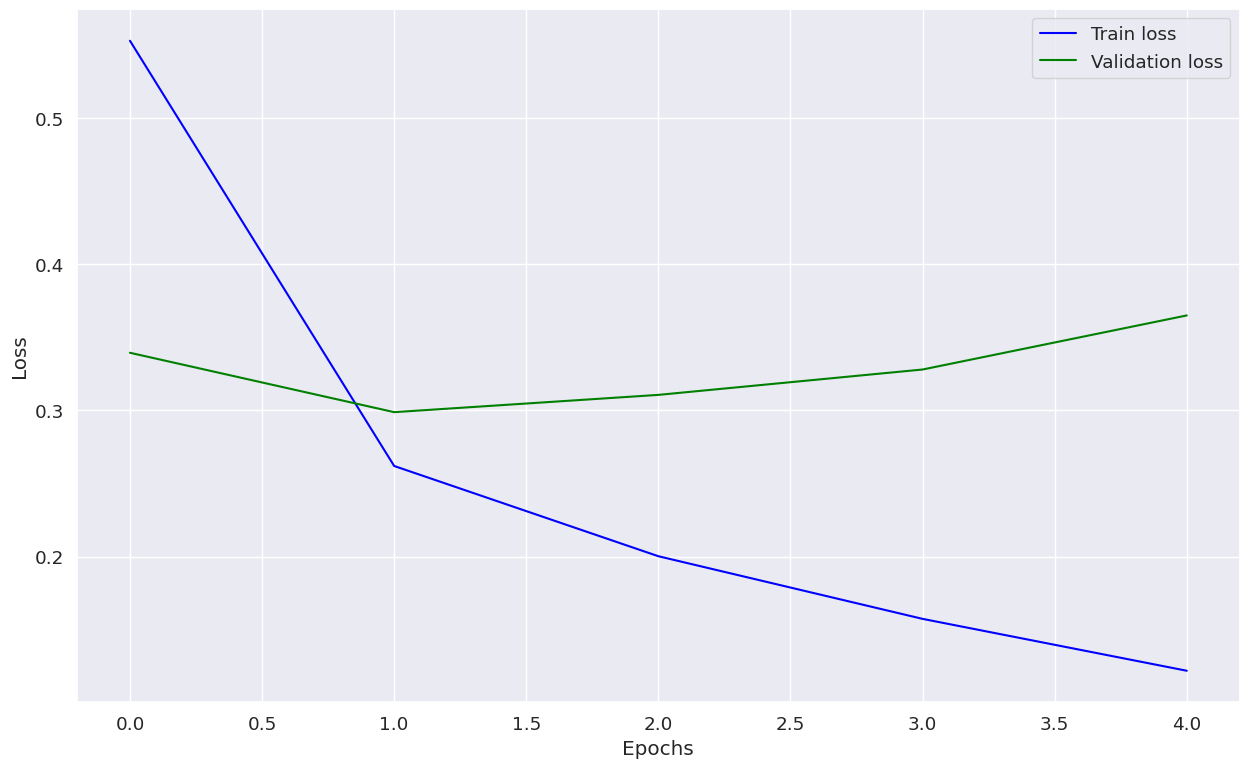

In [ ]:
plot_loss(history)

In [ ]:
print(f"Baseline accuracy: {evaluate(model, eval_dataloader)}")

Baseline accuracy: 0.896399974822998


# Experiments

## GRU

In [ ]:
model = model.cpu()
del model
torch.cuda.empty_cache()

Попробуем использовать GRU.

In [ ]:
class GRULM(torch.nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 4, agg_type: str = "max", dropout_rate: float = 0.1):
        super().__init__()
        self.rnn = torch.nn.Sequential(collections.OrderedDict([
            ("embedding", torch.nn.Embedding(vocab_size, hidden_dim)),
            ("rnn", torch.nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)),
        ]))
        self.fc = torch.nn.Sequential(collections.OrderedDict([
            ("fc0", torch.nn.Linear(hidden_dim, hidden_dim)),
            ("act0", torch.nn.Tanh()),
            ("drop", torch.nn.Dropout(p=dropout_rate)),
            ("fc1", torch.nn.Linear(hidden_dim, num_classes))
        ]))

        self.agg_type = agg_type
        if self.agg_type not in ["max", "mean"]:
            raise ValueError("Invalid aggregation type, expected one of: \"max\", \"mean\"")

    def forward(self, input):
        output, _ = self.rnn(input)

        match self.agg_type:
            case "max":
                output = output.max(dim=1)[0]
            case "mean":
                output = output.mean(dim=1)

        return self.fc(output)

In [ ]:
model = GRULM(hidden_dim=256, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=5)

Training:   0%|          | 0/5 [00:00<?, ?epoch/s]

Fitting epoch 1 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 1 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 2 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 2 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 3 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 3 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 4 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 4 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 5 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 5 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Overall training time:  226.8 seconds.


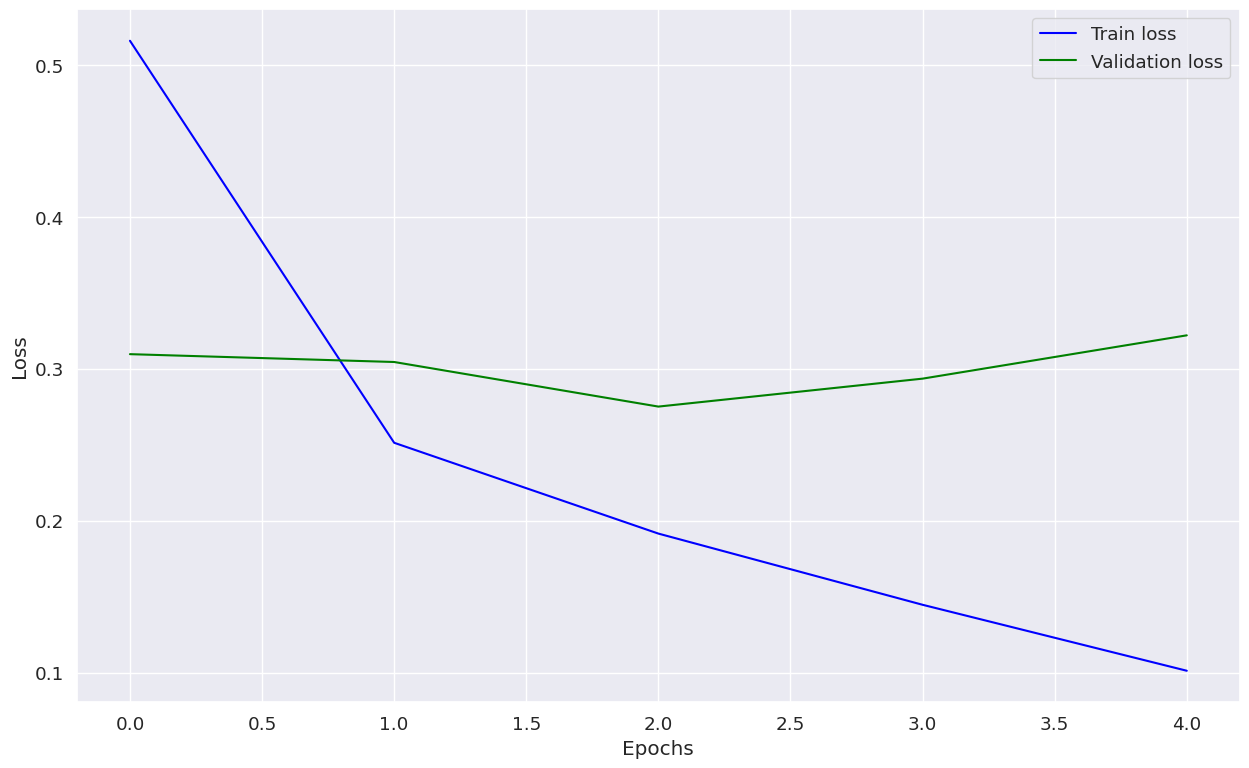

In [ ]:
plot_loss(history)

In [ ]:
print(f"GRU accuracy: {evaluate(model, eval_dataloader)}")

GRU accuracy: 0.9041999578475952


Уже лучше.

Попробуем использовать LSTM.

## LSTM

In [ ]:
model = model.cpu()
del model
torch.cuda.empty_cache()

In [ ]:
class LSTMLM(torch.nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 4, agg_type: str = "max", dropout_rate: float = 0.1):
        super().__init__()
        self.rnn = torch.nn.Sequential(collections.OrderedDict([
            ("embedding", torch.nn.Embedding(vocab_size, hidden_dim)),
            ("rnn", torch.nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)),
        ]))
        self.fc = torch.nn.Sequential(collections.OrderedDict([
            ("fc0", torch.nn.Linear(hidden_dim, hidden_dim)),
            ("act0", torch.nn.Tanh()),
            ("drop", torch.nn.Dropout(p=dropout_rate)),
            ("fc1", torch.nn.Linear(hidden_dim, num_classes))
        ]))

        self.agg_type = agg_type
        if self.agg_type not in ["max", "mean"]:
            raise ValueError("Invalid aggregation type, expected one of: \"max\", \"mean\"")

    def forward(self, input):
        output, _ = self.rnn(input)

        match self.agg_type:
            case "max":
                output = output.max(dim=1)[0]
            case "mean":
                output = output.mean(dim=1)

        return self.fc(output)

In [ ]:
model = LSTMLM(hidden_dim=256, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=5)

Training:   0%|          | 0/5 [00:00<?, ?epoch/s]

Fitting epoch 1 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 1 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 2 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 2 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 3 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 3 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 4 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 4 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 5 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 5 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Overall training time:  242.2 seconds.


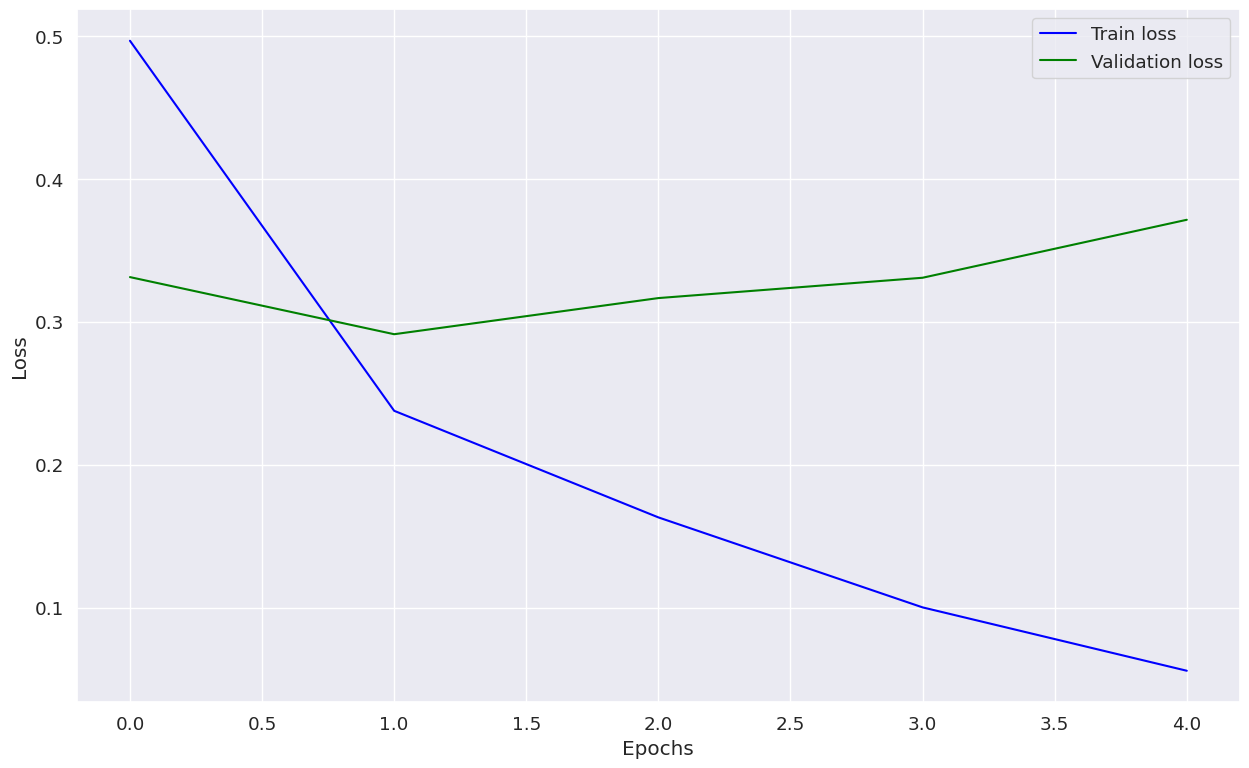

In [ ]:
plot_loss(history)

In [ ]:
print(f"LSTM accuracy: {evaluate(model, eval_dataloader)}")

LSTM accuracy: 0.9045999646186829


Тоже лучше, причём метрика выше, чем при использовании GRU. Остановимся на LSTM.

Заметно, что уже после первой эпохи лосс на валидации идёт вверх, так что попробуем снизить learn rate. Проверим "Karpathy constant" 
(`3e-4`)

## LR change

In [ ]:
model = model.cpu()
del model
torch.cuda.empty_cache()

In [ ]:
model = LSTMLM(hidden_dim=256, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=5)

Training:   0%|          | 0/5 [00:00<?, ?epoch/s]

Fitting epoch 1 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 1 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 2 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 2 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 3 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 3 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 4 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 4 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 5 / 5:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 5 / 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Overall training time:  236.4 seconds.


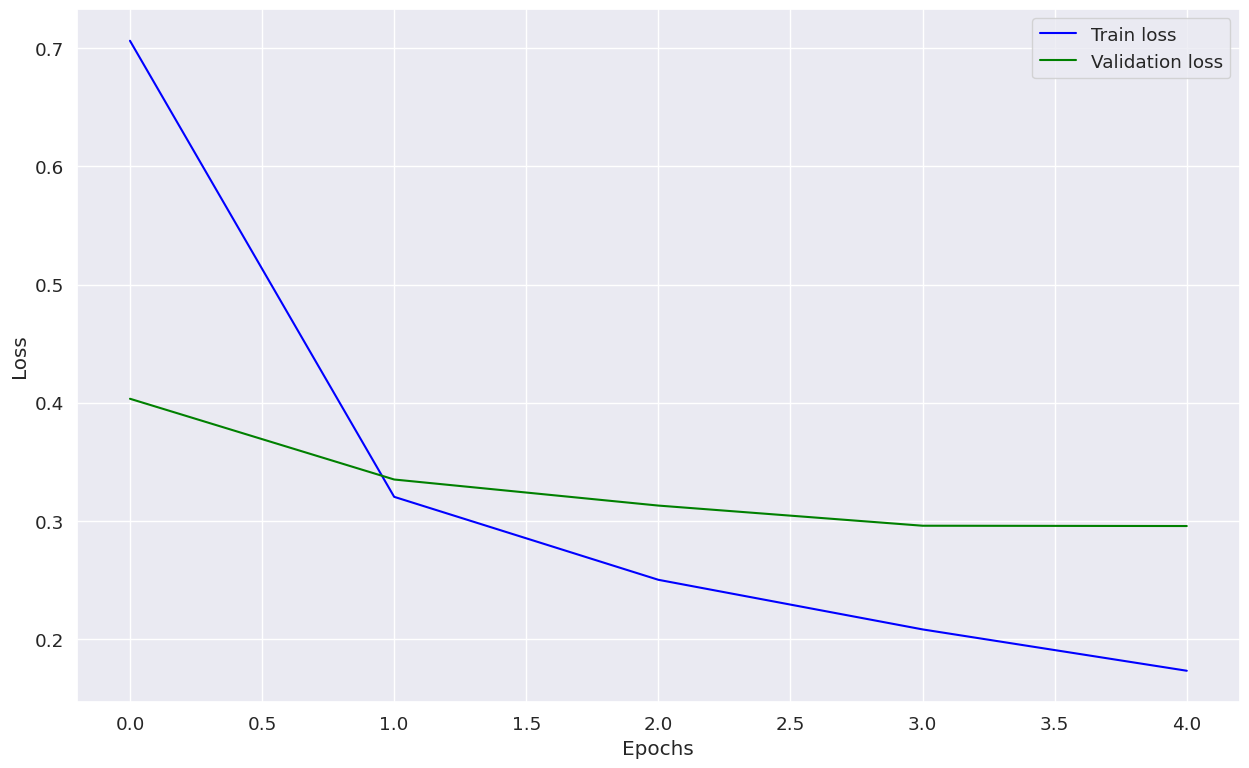

In [ ]:
plot_loss(history)

In [ ]:
print(f"LSTM (5 ep, lr=3e-4) accuracy: {evaluate(model, eval_dataloader)}")

LSTM (5 ep, lr=3e-4) accuracy: 0.902999997138977


Возможно, теперь мы недообучились. Продлим обучение на ещё 5 эпох с тем же LR.

## Training extension (10 epochs)

In [ ]:
history += train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=10, start_epoch=5)

Training:   0%|          | 0/5 [00:00<?, ?epoch/s]

Fitting epoch 6 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 6 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 7 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 7 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 8 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 8 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 9 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 9 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 10 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 10 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Overall training time:  229.0 seconds.


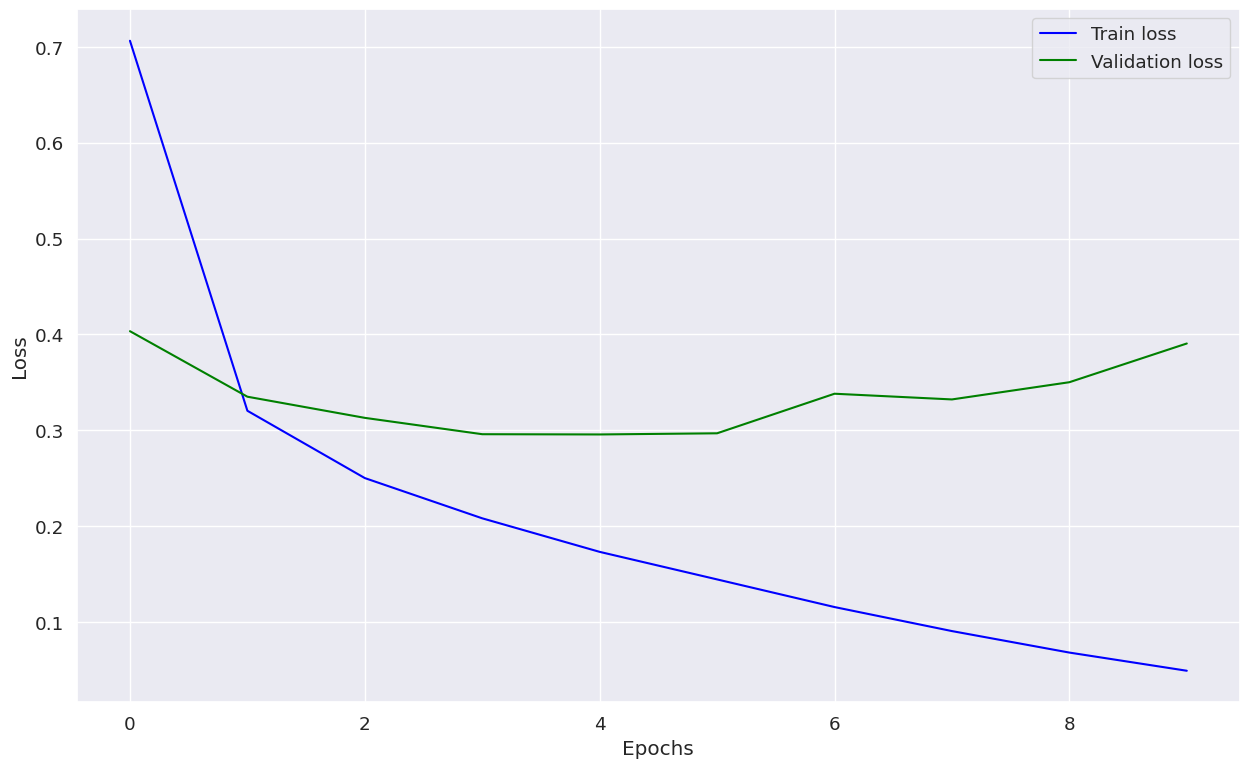

In [ ]:
plot_loss(history)

In [ ]:
print(f"LSTM (10 ep, lr=3e-4) accuracy: {evaluate(model, eval_dataloader)}")

LSTM (10 ep, lr=3e-4) accuracy: 0.902999997138977


После пятой эпохи лосс на валидации снова пошёл вверх, так что либо после 5 эпохи уже достигнут минимум, либо необходимо снижать LR после 5 эпох дальше, что мы и попробуем сделать (используем `ReduceLROnPlateau`)

## Training with scheduling

In [ ]:
model = model.cpu()
del model
torch.cuda.empty_cache()

In [ ]:
model = LSTMLM(hidden_dim=256, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)

In [ ]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=10, scheduler=scheduler)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Fitting epoch 1 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 1 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 2 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 2 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 3 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 3 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 4 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 4 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 5 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 5 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 6 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 6 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 7 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 7 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 8 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 8 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 9 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 9 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 10 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 10 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Overall training time:  464.3 seconds.


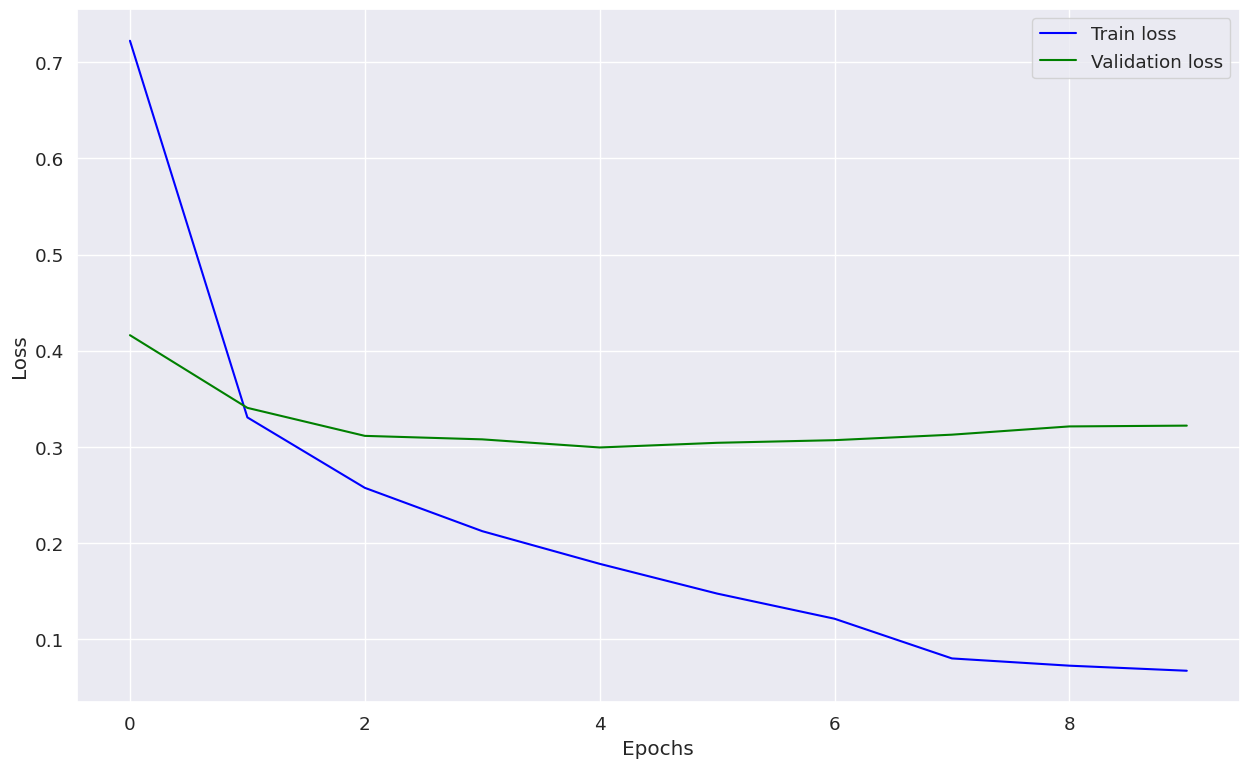

In [ ]:
plot_loss(history)

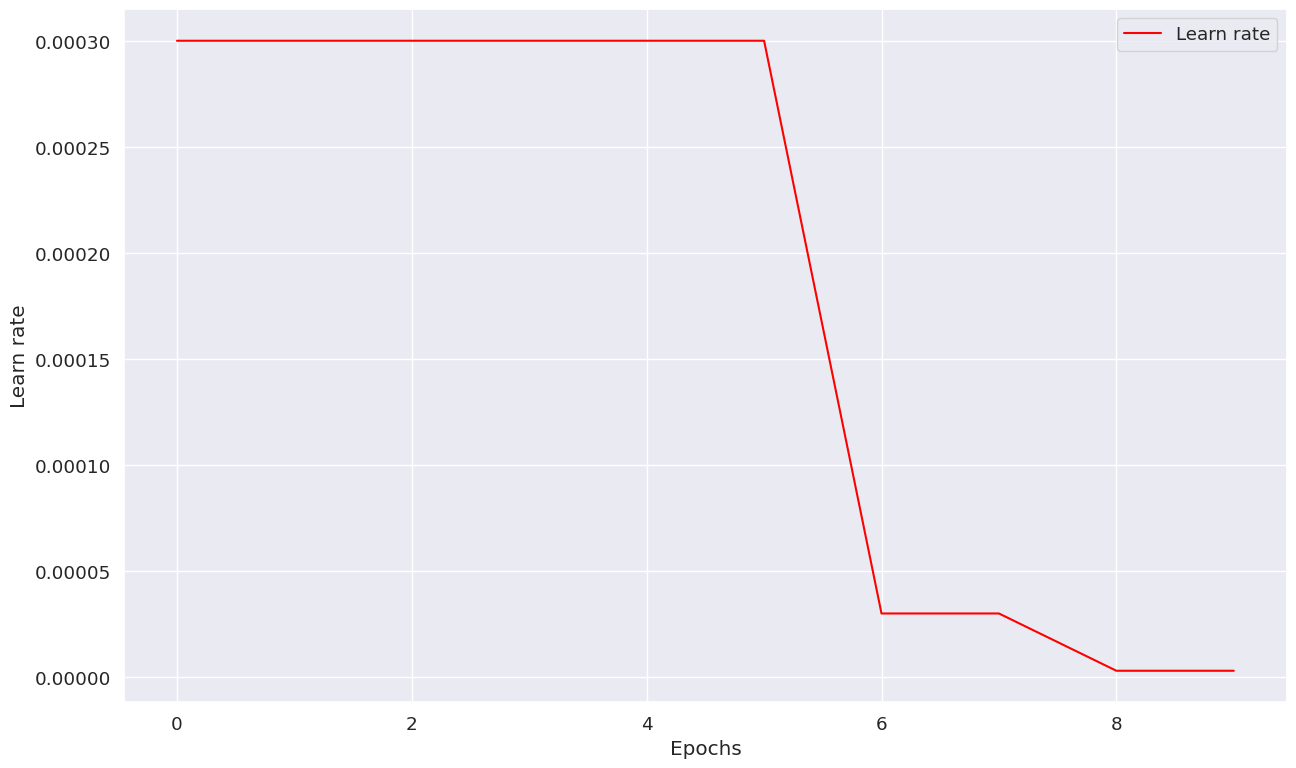

In [ ]:
plot_learn_rate(history)

In [ ]:
print(f"LSTM (10 ep, lr=3e-4 with scheduler) accuracy: {evaluate(model, eval_dataloader)}")

LSTM (10 ep, lr=3e-4 with scheduler) accuracy: 0.9079999923706055


Лосс на валидации не снизился, но метрика выше, так что оставим такой порядок обучения и перейдём к другим экспериментам.

## Vocab size changing

Попробуем изменить размер словаря (сначала уменьшим отрезку по частоте вхождения).

In [ ]:
model = model.cpu()
del model
torch.cuda.empty_cache()

In [ ]:
vocab, word2ind, ind2word = create_vocab(dataset, 10)
print(f"Vocabulary size: {len(vocab)}")
train_dataset = WordDataset(dataset["train"])
idx = torch.randperm(len(dataset["test"]))[:5000]
eval_dataset = WordDataset(dataset["test"].select(idx))

train_dataloader = data_utils.DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, 
    batch_size=BATCH_SIZE, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True)

eval_dataloader = data_utils.DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, 
    batch_size=BATCH_SIZE, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True)

Preprocessing:   0%|          | 0/120000 [00:00<?, ?examples/s]

Selecting frequent tokens:   0%|          | 0/102166 [00:00<?, ?tokens/s]

Vocabulary size: 19562


In [ ]:
model = LSTMLM(hidden_dim=256, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)

In [ ]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=10, scheduler=scheduler)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Fitting epoch 1 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 1 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 2 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 2 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 3 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 3 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 4 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 4 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 5 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 5 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 6 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 6 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 7 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 7 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 8 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 8 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 9 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 9 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 10 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 10 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Overall training time:  463.8 seconds.


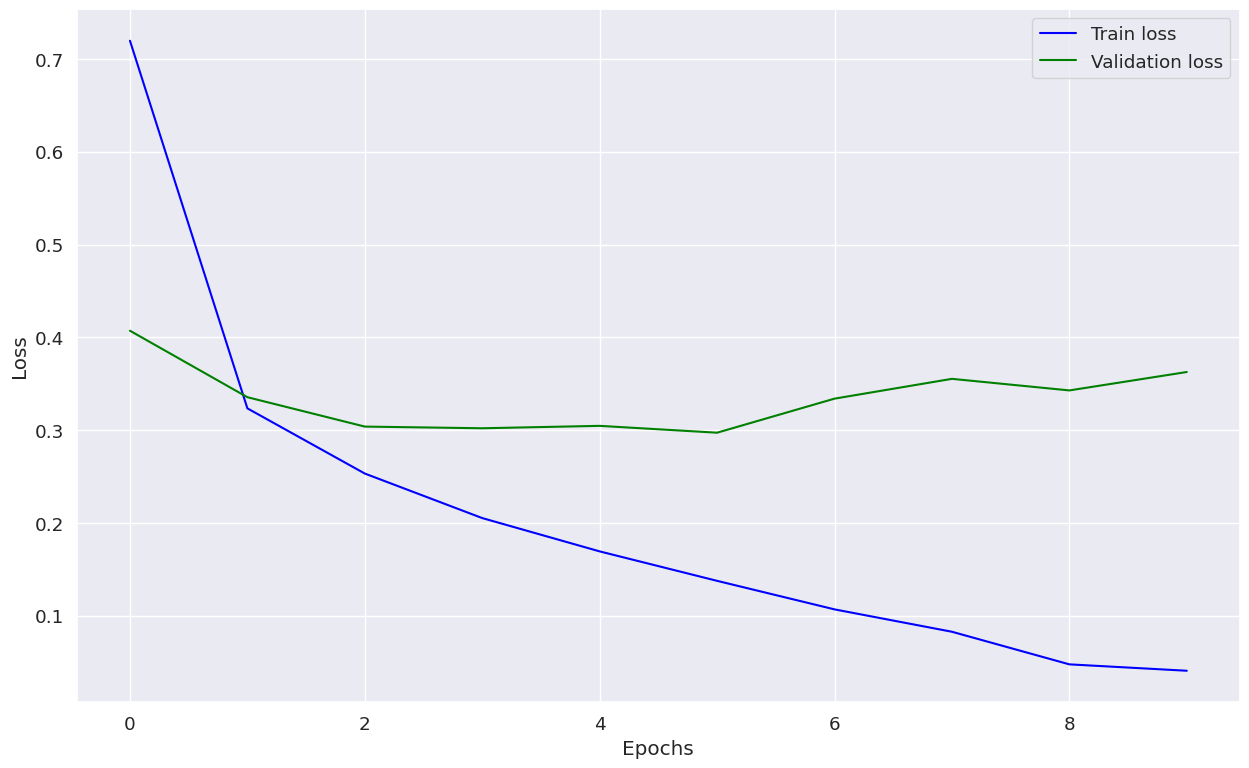

In [ ]:
plot_loss(history)

In [ ]:
print(f"LSTM (10 ep, lr=3e-4 with scheduler, counter threshold: 10) accuracy: {evaluate(model, eval_dataloader)}")

LSTM (10 ep, lr=3e-4 with scheduler, counter threshold: 10) accuracy: 0.9041999578475952


Увеличение словаря не помогло, поэтому попробуем обратное действие и уменьшим его размер (увеличив отрезку по частоте вхождения).

In [ ]:
model = model.cpu()
del model
torch.cuda.empty_cache()

In [ ]:
vocab, word2ind, ind2word = create_vocab(dataset, 50)
print(f"Vocabulary size: {len(vocab)}")
train_dataset = WordDataset(dataset["train"])
idx = torch.randperm(len(dataset["test"]))[:5000]
eval_dataset = WordDataset(dataset["test"].select(idx))

train_dataloader = data_utils.DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, 
    batch_size=BATCH_SIZE, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True)

eval_dataloader = data_utils.DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, 
    batch_size=BATCH_SIZE, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True)

Preprocessing:   0%|          | 0/120000 [00:00<?, ?examples/s]

Selecting frequent tokens:   0%|          | 0/102166 [00:00<?, ?tokens/s]

Vocabulary size: 7787


In [ ]:
model = LSTMLM(hidden_dim=256, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)

In [ ]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=10, scheduler=scheduler)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Fitting epoch 1 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 1 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 2 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 2 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 3 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 3 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 4 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 4 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 5 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 5 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 6 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 6 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 7 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 7 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 8 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 8 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 9 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 9 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 10 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 10 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Overall training time:  458.5 seconds.


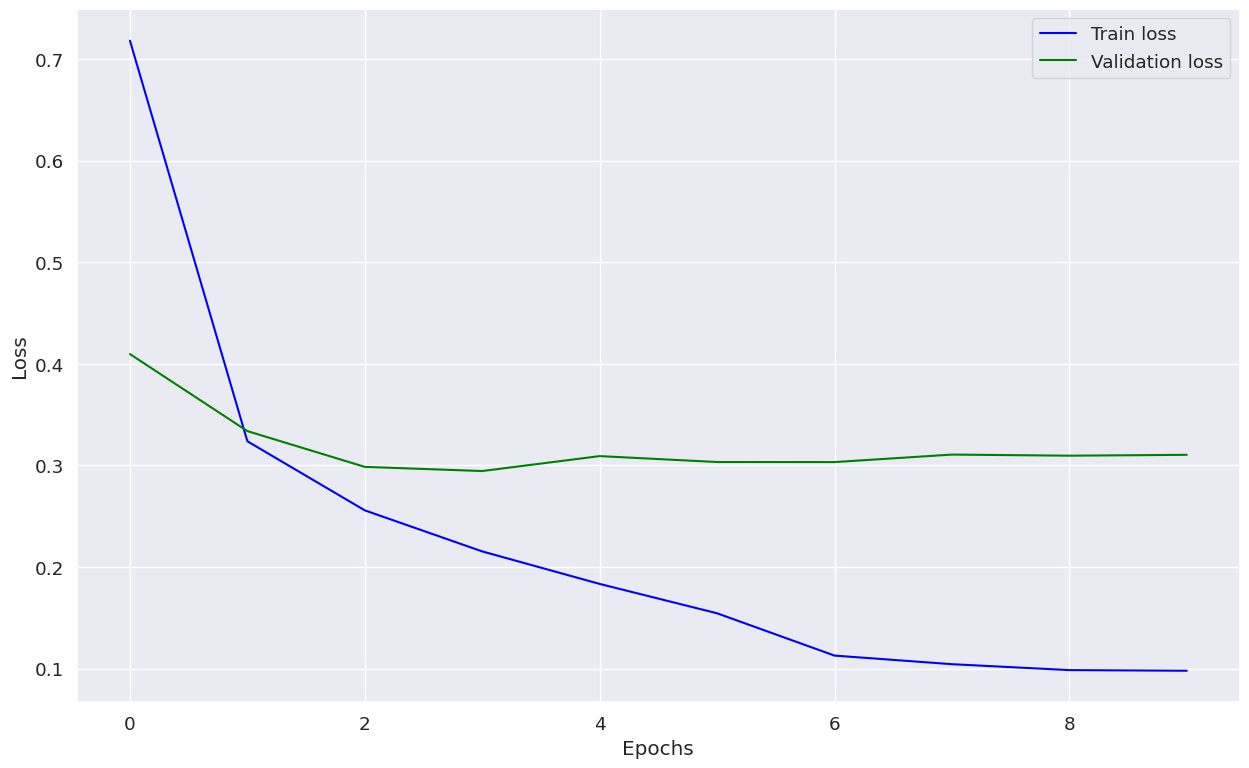

In [ ]:
plot_loss(history)

In [ ]:
print(f"LSTM (10 ep, lr=3e-4 with scheduler, counter threshold: 50) accuracy: {evaluate(model, eval_dataloader)}")

LSTM (10 ep, lr=3e-4 with scheduler, counter threshold: 50) accuracy: 0.9035999774932861


Аналогично предыдущему эксперименту, видно снижение метрики. Вернём отрезку к изначальному значению и проверим другие варианты. 

In [ ]:
vocab, word2ind, ind2word = create_vocab(dataset, 10)
print(f"Vocabulary size: {len(vocab)}")
train_dataset = WordDataset(dataset["train"])
idx = torch.randperm(len(dataset["test"]))[:5000]
eval_dataset = WordDataset(dataset["test"].select(idx))

train_dataloader = data_utils.DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, 
    batch_size=BATCH_SIZE, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True)

eval_dataloader = data_utils.DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, 
    batch_size=BATCH_SIZE, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True)

Preprocessing:   0%|          | 0/120000 [00:00<?, ?examples/s]

Selecting frequent tokens:   0%|          | 0/102166 [00:00<?, ?tokens/s]

Vocabulary size: 19562


## Hidden state dimensionality manipulation

Попробуем увеличить размер скрытого состояния (до 384).

In [ ]:
model = model.cpu()
del model
torch.cuda.empty_cache()

In [ ]:
model = LSTMLM(hidden_dim=384, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)

In [ ]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=10, scheduler=scheduler)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Fitting epoch 1 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 1 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 2 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 2 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 3 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 3 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 4 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 4 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 5 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 5 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 6 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 6 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 7 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 7 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 8 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 8 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 9 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 9 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 10 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 10 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Overall training time:  514.1 seconds.


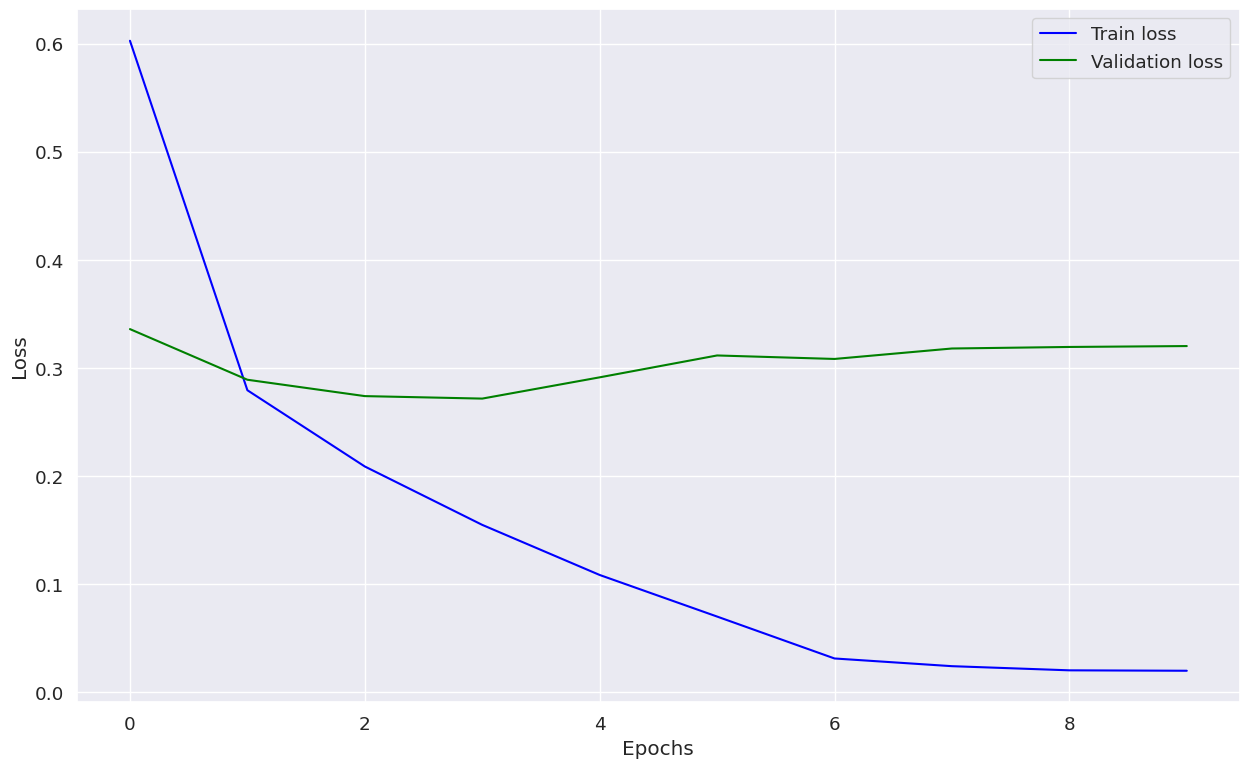

In [ ]:
plot_loss(history)

In [ ]:
print(f"LSTM (10 ep, lr=3e-4 with scheduler, hidden dim: 384) accuracy: {evaluate(model, eval_dataloader)}")

LSTM (10 ep, lr=3e-4 with scheduler, hidden dim: 384) accuracy: 0.9125999808311462


Результат улучшился (ожидаемо). Попробуем размер 512.

In [ ]:
model = model.cpu()
del model
torch.cuda.empty_cache()

In [ ]:
model = LSTMLM(hidden_dim=512, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)

In [ ]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=10, scheduler=scheduler)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Fitting epoch 1 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 1 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 2 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 2 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 3 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 3 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 4 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 4 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 5 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 5 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 6 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 6 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 7 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 7 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 8 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 8 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 9 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 9 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 10 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 10 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Overall training time:  587.7 seconds.


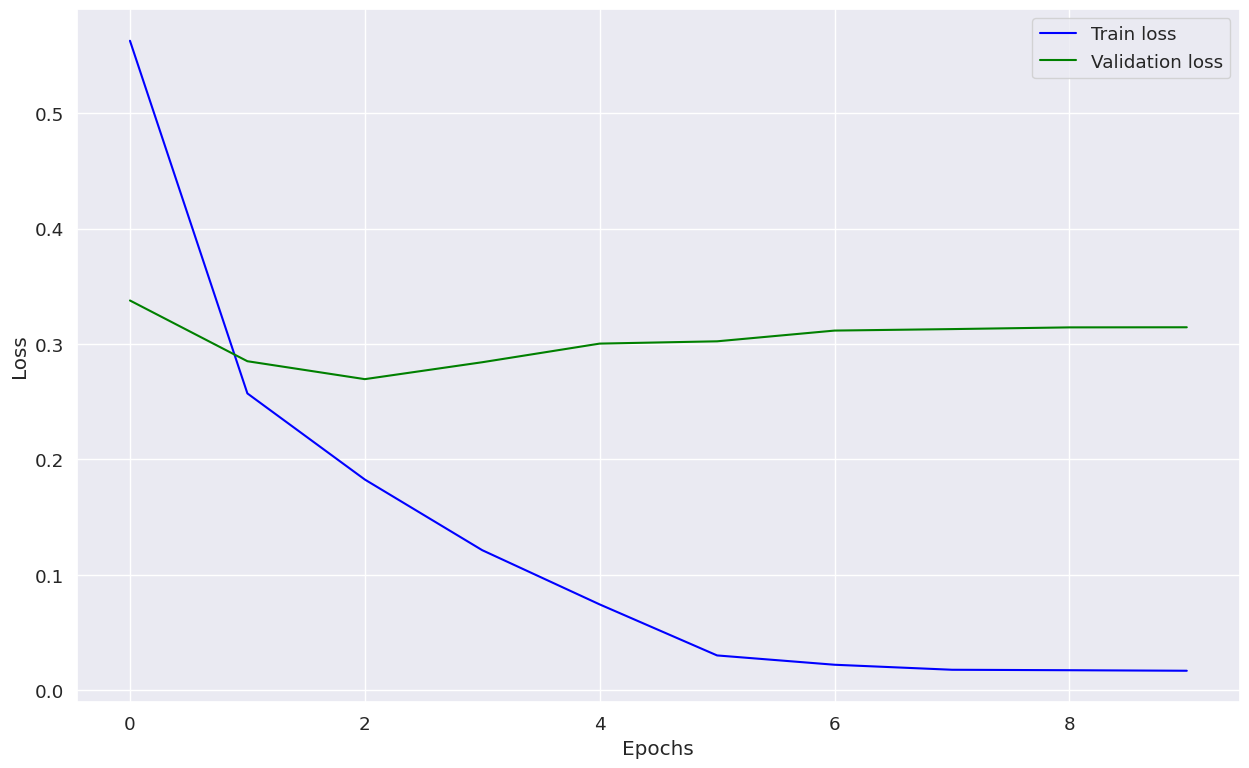

In [ ]:
plot_loss(history)

In [ ]:
print(f"LSTM (10 ep, lr=3e-4 with scheduler, hidden dim: 512) accuracy: {evaluate(model, eval_dataloader)}")

LSTM (10 ep, lr=3e-4 with scheduler, hidden dim: 512) accuracy: 0.9149999618530273


Хороший результат, но можно ли получить ещё больше? Попробуем размер 768.

In [ ]:
model = model.cpu()
del model
torch.cuda.empty_cache()

In [ ]:
model = LSTMLM(hidden_dim=768, vocab_size=len(vocab)).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)

In [ ]:
history = train(train_dataloader, eval_dataloader, model, optimizer, criterion, epochs=10, scheduler=scheduler)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Fitting epoch 1 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 1 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 2 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 2 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 3 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 3 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 4 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 4 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 5 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 5 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 6 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 6 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 7 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 7 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 8 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 8 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 9 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 9 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Fitting epoch 10 / 10:   0%|          | 0/235 [00:00<?, ?batch/s]

Evaluating epoch 10 / 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Overall training time:  1045.3 seconds.


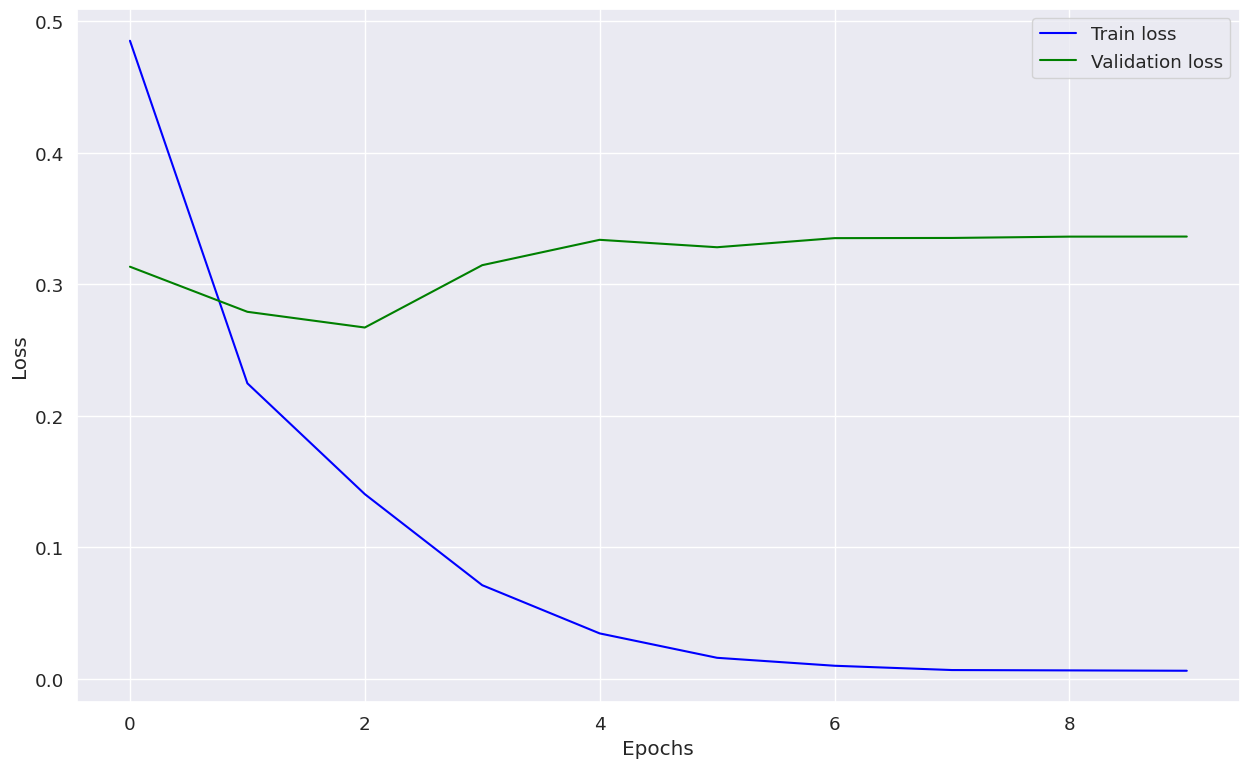

In [ ]:
plot_loss(history)

In [ ]:
print(f"LSTM (10 ep, lr=3e-4 with scheduler, hidden dim: 768) accuracy: {evaluate(model, eval_dataloader)}")

LSTM (10 ep, lr=3e-4 with scheduler, hidden dim: 768) accuracy: 0.9165999889373779


Поскольку порог в 0.915 accuracy был пройден, нет смысла поднимать размер hidden state дальше.

# Вывод

Было проведено 10 экспериментов:

— Изменение архитектуры (использование GRU или LSTM вместо обычной RNN).

— Cмена learn rate (понижение до `3e-4`, а также использование автоматического снижения LR с помощью scheduler).

— Изменение размера словаря.

— Изменение размера скрытого состояния.

Наибольшее влияние на качество возымело изменение размера hidden statе.

Модель достаточно легко переобучить, примерно после 5 эпохи с LR `3e-4` функция потери на валидационных данных уже растёт, однако, динамическое понижение learn rate несколько снижает этот эффект (и увеличивает accuracy, поэтому и было выбрано обучение на 10 эпох с scheduler).

Наилучшей моделью является модель, основанная на LSTM, с размером hidden state, равным 768, обученная 10 эпох с начальным LR `3e-4` и снижением LR в 10 раз через 2 эпохи стагнации валидационного лосса. 